In [ ]:
## all the imports

import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm


from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"
     

/home/hp/anaconda3/envs/generic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# fix the seed so that the output matches
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
# sample code snip to train a classification model

def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [ ]:
# codes to check the performance of the model

def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
## data loading operations

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define image size and transformations
image_size = 224  # ResNet-18 standard input size is 224x224
transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(image_size),  # Random resize and crop to 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for pre-trained models
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256 to maintain aspect ratio
        transforms.CenterCrop(image_size),  # Crop to 224x224 from the center
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for pre-trained models
    ]),
}

# Define dataset paths
train_dir = "/media/hp/New Volume/teja_works/tinyml/dataset/seg_train/seg_train"  # Update path to the train directory
test_dir = "/media/hp/New Volume/teja_works/tinyml/dataset/seg_test/seg_test"    # Update path to the test directory

# Create dataset and dataloader for each split (train and test)
dataset = {}
for split in ["train", "test"]:
    if split == "train":
        dataset[split] = ImageFolder(
            root=train_dir,
            transform=transforms["train"],
        )
    else:
        dataset[split] = ImageFolder(
            root=test_dir,
            transform=transforms["test"],
        )

# Create dataloader for each split (train and test)
dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=32,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True,
    )


In [7]:
!pip install timm

In [ ]:
# model init


class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self, classes = 6) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, classes)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x



model = VGG(classes=6).cuda()     

In [9]:
model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

In [ ]:
# evalution code


@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()# just a random pretrained model

In [ ]:
# model without training leading to bad accurcay
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense model has accuracy=17.00%
dense model has size=35.20 MiB


In [ ]:
## training model for few epochs

from tqdm import tqdm

# Initialize variables for tracking progress
best_sparse_model_checkpoint = dict()
best_accuracy = 0

print(f'Finetuning Fine-grained Pruned Sparse Model')


num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')



# Training loop
for epoch in range(num_finetune_epochs):
    print(f"Epoch [{epoch+1}/{num_finetune_epochs}]")

    # Train phase
    train(model, dataloader['train'], criterion, optimizer, scheduler)

    # Validation phase (optional but recommended)
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for inputs, targets in tqdm(dataloader['test'], desc='test', leave=False):
            # Move the data to GPU
            inputs = inputs.cuda()
            targets = targets.cuda()

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update correct and total counts
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Compute accuracy
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_finetune_epochs}] - Test Accuracy: {accuracy:.2f}%")

    # Save the model if it's the best one so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sparse_model_checkpoint['model_state_dict'] = model.state_dict()
        best_sparse_model_checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        best_sparse_model_checkpoint['epoch'] = epoch
        best_sparse_model_checkpoint['accuracy'] = accuracy
        print(f"Best model updated with accuracy: {best_accuracy:.2f}%")

# Save the best model checkpoint after training is complete
torch.save(best_sparse_model_checkpoint, 'best_finetuned_model.pth')
print(f"Best model saved with accuracy: {best_accuracy:.2f}%")


Finetuning Fine-grained Pruned Sparse Model
Finetuning Fine-grained Pruned Sparse Model
Epoch [1/5]


Epoch [1/5] - Test Accuracy: 72.20%
Best model updated with accuracy: 72.20%
Epoch [2/5]


Epoch [2/5] - Test Accuracy: 75.33%
Best model updated with accuracy: 75.33%
Epoch [3/5]


Epoch [3/5] - Test Accuracy: 75.53%
Best model updated with accuracy: 75.53%
Epoch [4/5]


Epoch [4/5] - Test Accuracy: 81.90%
Best model updated with accuracy: 81.90%
Epoch [5/5]


Epoch [5/5] - Test Accuracy: 81.50%
Best model saved with accuracy: 81.90%


In [ ]:
# the accuracy of the trained model

dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense model has accuracy=81.50%
dense model has size=35.20 MiB


In [15]:
model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

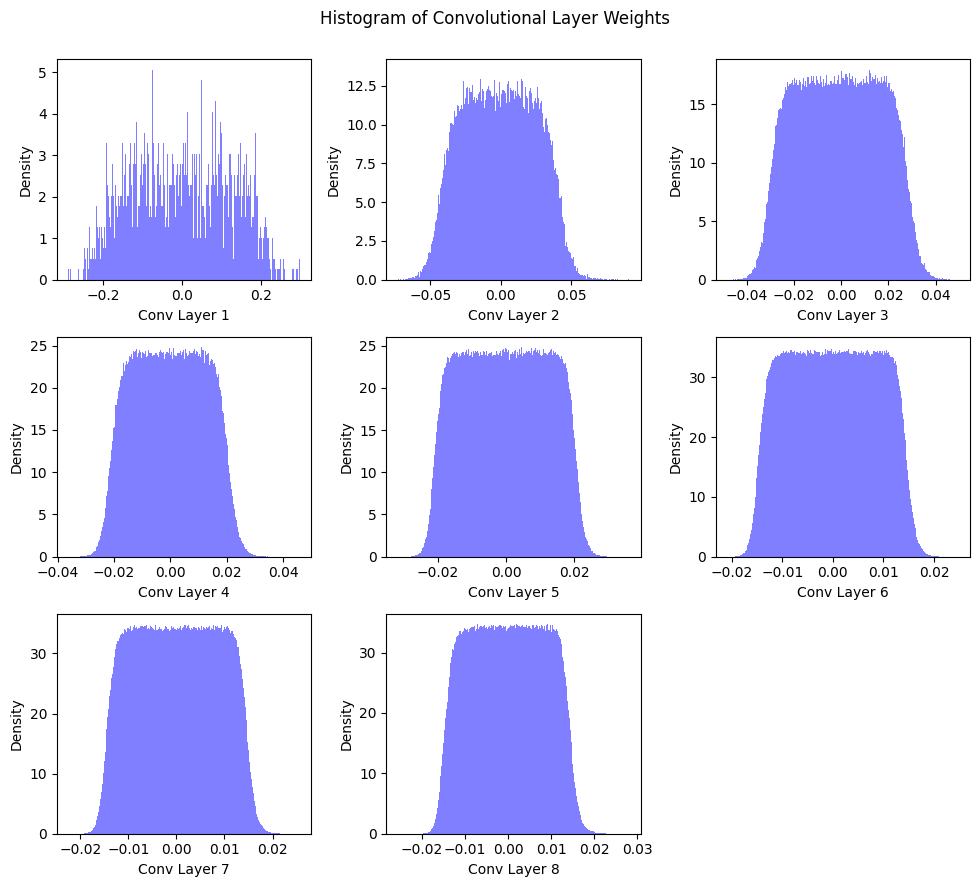

In [ ]:
## this is the plot of the weights to show that most of the distribution is around the 0

import matplotlib.pyplot as plt
import torch

def plot_conv_weights(model, bins=256, count_nonzero_only=False):
    # List of convolutional layers
    conv_layers = [module for module in model.modules() if isinstance(module, torch.nn.Conv2d)]
    
    # Determine the number of subplots needed
    num_plots = len(conv_layers)
    rows = (num_plots // 3) + (num_plots % 3 > 0)  # Calculate rows based on number of layers
    cols = 3  # Set the number of columns to 3
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, rows*3))
    axes = axes.ravel()  # Flatten axes to easily index
    
    # Plot each convolutional layer's weights
    for plot_index, conv_layer in enumerate(conv_layers):
        ax = axes[plot_index]
        if count_nonzero_only:
            # Extract the weights, flatten them, and keep only non-zero weights
            param_cpu = conv_layer.weight.detach().view(-1).cpu()
            param_cpu = param_cpu[param_cpu != 0].view(-1)
            ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)
        else:
            # Flatten the weights and plot
            ax.hist(conv_layer.weight.detach().view(-1).cpu(), bins=bins, density=True, color='blue', alpha=0.5)
        
        ax.set_xlabel(f'Conv Layer {plot_index+1}')
        ax.set_ylabel('Density')

    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        axes[i].axis('off')
    
    fig.suptitle('Histogram of Convolutional Layer Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

# Call the function with your model
plot_conv_weights(model)


In [ ]:



def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask




    
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []

    # Filter to only include convolutional layers
    named_conv_weights = []

    # Iterate over the named modules to find convolutional layers
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            # Add the convolutional layer's parameters to the list
            for param_name, param in module.named_parameters():
                named_conv_weights.append((f"{name}.{param_name}", param))

    # Check if named_conv_weights is populated
    if len(named_conv_weights) == 0:
        print("No convolutional layers found!")
        return sparsities, accuracies

    # Iterate over convolutional layers
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'Scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            # Apply pruning to the parameter
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            
            # Restore original parameter values
            param.copy_(param_clone)
            accuracy.append(acc)
        
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    
    return sparsities, accuracies

sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

Scanning 0/8 weight - backbone.conv0.weight:  17%|█▋        | 1/6 [00:11<00:57, 11.52s/it]

    sparsity=0.40: accuracy=80.77%

Scanning 0/8 weight - backbone.conv0.weight:  33%|███▎      | 2/6 [00:23<00:46, 11.58s/it]

    sparsity=0.50: accuracy=78.60%

Scanning 0/8 weight - backbone.conv0.weight:  50%|█████     | 3/6 [00:35<00:35, 11.74s/it]

    sparsity=0.60: accuracy=78.03%

Scanning 0/8 weight - backbone.conv0.weight:  67%|██████▋   | 4/6 [00:46<00:22, 11.48s/it]

    sparsity=0.70: accuracy=72.13%

Scanning 0/8 weight - backbone.conv0.weight:  83%|████████▎ | 5/6 [00:57<00:11, 11.30s/it]

    sparsity=0.80: accuracy=67.70%

Scanning 0/8 weight - backbone.conv0.weight: 100%|██████████| 6/6 [01:08<00:00, 11.36s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[80.77%, 78.60%, 78.03%, 72.13%, 67.70%, 49.30%]

Scanning 1/8 weight - backbone.conv1.weight:  17%|█▋        | 1/6 [00:11<00:56, 11.21s/it]

    sparsity=0.40: accuracy=81.40%

Scanning 1/8 weight - backbone.conv1.weight:  33%|███▎      | 2/6 [00:22<00:44, 11.10s/it]

    sparsity=0.50: accuracy=81.27%

Scanning 1/8 weight - backbone.conv1.weight:  50%|█████     | 3/6 [00:33<00:33, 11.02s/it]

    sparsity=0.60: accuracy=81.47%

Scanning 1/8 weight - backbone.conv1.weight:  67%|██████▋   | 4/6 [00:44<00:22, 11.03s/it]

    sparsity=0.70: accuracy=81.00%

Scanning 1/8 weight - backbone.conv1.weight:  83%|████████▎ | 5/6 [00:54<00:10, 10.94s/it]

    sparsity=0.80: accuracy=79.20%

Scanning 1/8 weight - backbone.conv1.weight: 100%|██████████| 6/6 [01:06<00:00, 11.00s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[81.40%, 81.27%, 81.47%, 81.00%, 79.20%, 69.17%]

Scanning 2/8 weight - backbone.conv2.weight:  17%|█▋        | 1/6 [00:11<00:55, 11.11s/it]

    sparsity=0.40: accuracy=81.20%

Scanning 2/8 weight - backbone.conv2.weight:  33%|███▎      | 2/6 [00:22<00:44, 11.02s/it]

    sparsity=0.50: accuracy=81.47%

Scanning 2/8 weight - backbone.conv2.weight:  50%|█████     | 3/6 [00:33<00:32, 10.99s/it]

    sparsity=0.60: accuracy=81.10%

Scanning 2/8 weight - backbone.conv2.weight:  67%|██████▋   | 4/6 [00:43<00:21, 10.95s/it]

    sparsity=0.70: accuracy=79.93%

Scanning 2/8 weight - backbone.conv2.weight:  83%|████████▎ | 5/6 [00:54<00:10, 10.92s/it]

    sparsity=0.80: accuracy=78.30%

Scanning 2/8 weight - backbone.conv2.weight: 100%|██████████| 6/6 [01:05<00:00, 10.95s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[81.20%, 81.47%, 81.10%, 79.93%, 78.30%, 67.87%]

Scanning 3/8 weight - backbone.conv3.weight:  17%|█▋        | 1/6 [00:10<00:54, 10.88s/it]

    sparsity=0.40: accuracy=81.07%

Scanning 3/8 weight - backbone.conv3.weight:  33%|███▎      | 2/6 [00:21<00:43, 10.86s/it]

    sparsity=0.50: accuracy=81.23%

Scanning 3/8 weight - backbone.conv3.weight:  50%|█████     | 3/6 [00:32<00:32, 10.85s/it]

    sparsity=0.60: accuracy=80.77%

Scanning 3/8 weight - backbone.conv3.weight:  67%|██████▋   | 4/6 [00:43<00:21, 10.86s/it]

    sparsity=0.70: accuracy=78.63%

Scanning 3/8 weight - backbone.conv3.weight:  83%|████████▎ | 5/6 [00:54<00:10, 10.84s/it]

    sparsity=0.80: accuracy=74.47%

Scanning 3/8 weight - backbone.conv3.weight: 100%|██████████| 6/6 [01:05<00:00, 10.85s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[81.07%, 81.23%, 80.77%, 78.63%, 74.47%, 53.57%]

Scanning 4/8 weight - backbone.conv4.weight:  17%|█▋        | 1/6 [00:12<01:00, 12.09s/it]

    sparsity=0.40: accuracy=80.97%

Scanning 4/8 weight - backbone.conv4.weight:  33%|███▎      | 2/6 [00:25<00:52, 13.13s/it]

    sparsity=0.50: accuracy=79.63%

Scanning 4/8 weight - backbone.conv4.weight:  50%|█████     | 3/6 [00:39<00:40, 13.36s/it]

    sparsity=0.60: accuracy=78.83%

Scanning 4/8 weight - backbone.conv4.weight:  67%|██████▋   | 4/6 [00:53<00:27, 13.60s/it]

    sparsity=0.70: accuracy=78.23%

Scanning 4/8 weight - backbone.conv4.weight:  83%|████████▎ | 5/6 [01:07<00:13, 13.71s/it]

    sparsity=0.80: accuracy=73.63%

Scanning 4/8 weight - backbone.conv4.weight: 100%|██████████| 6/6 [01:21<00:00, 13.56s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[80.97%, 79.63%, 78.83%, 78.23%, 73.63%, 64.17%]

Scanning 5/8 weight - backbone.conv5.weight:  17%|█▋        | 1/6 [00:14<01:10, 14.04s/it]

    sparsity=0.40: accuracy=81.10%

Scanning 5/8 weight - backbone.conv5.weight:  33%|███▎      | 2/6 [00:28<00:56, 14.01s/it]

    sparsity=0.50: accuracy=80.53%

Scanning 5/8 weight - backbone.conv5.weight:  50%|█████     | 3/6 [00:41<00:41, 13.97s/it]

    sparsity=0.60: accuracy=80.20%

Scanning 5/8 weight - backbone.conv5.weight:  67%|██████▋   | 4/6 [00:55<00:27, 13.96s/it]

    sparsity=0.70: accuracy=79.37%

Scanning 5/8 weight - backbone.conv5.weight:  83%|████████▎ | 5/6 [01:09<00:13, 13.94s/it]

    sparsity=0.80: accuracy=76.93%

Scanning 5/8 weight - backbone.conv5.weight: 100%|██████████| 6/6 [01:23<00:00, 13.96s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[81.10%, 80.53%, 80.20%, 79.37%, 76.93%, 66.07%]

Scanning 6/8 weight - backbone.conv6.weight:  17%|█▋        | 1/6 [00:14<01:10, 14.02s/it]

    sparsity=0.40: accuracy=81.70%

Scanning 6/8 weight - backbone.conv6.weight:  33%|███▎      | 2/6 [00:27<00:55, 13.80s/it]

    sparsity=0.50: accuracy=81.60%

Scanning 6/8 weight - backbone.conv6.weight:  50%|█████     | 3/6 [00:41<00:41, 13.86s/it]

    sparsity=0.60: accuracy=82.07%

Scanning 6/8 weight - backbone.conv6.weight:  67%|██████▋   | 4/6 [00:55<00:27, 13.89s/it]

    sparsity=0.70: accuracy=82.20%

Scanning 6/8 weight - backbone.conv6.weight:  83%|████████▎ | 5/6 [01:09<00:13, 13.91s/it]

    sparsity=0.80: accuracy=81.53%

Scanning 6/8 weight - backbone.conv6.weight: 100%|██████████| 6/6 [01:20<00:00, 13.45s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[81.70%, 81.60%, 82.07%, 82.20%, 81.53%, 72.27%]

Scanning 7/8 weight - backbone.conv7.weight:  17%|█▋        | 1/6 [00:13<01:06, 13.37s/it]

    sparsity=0.40: accuracy=81.60%

Scanning 7/8 weight - backbone.conv7.weight:  33%|███▎      | 2/6 [00:27<00:55, 13.76s/it]

    sparsity=0.50: accuracy=81.73%

Scanning 7/8 weight - backbone.conv7.weight:  50%|█████     | 3/6 [00:41<00:41, 13.94s/it]

    sparsity=0.60: accuracy=81.57%

Scanning 7/8 weight - backbone.conv7.weight:  67%|██████▋   | 4/6 [00:55<00:27, 13.98s/it]

    sparsity=0.70: accuracy=81.83%

Scanning 7/8 weight - backbone.conv7.weight:  83%|████████▎ | 5/6 [01:09<00:13, 13.95s/it]

    sparsity=0.80: accuracy=81.33%

Scanning 7/8 weight - backbone.conv7.weight: 100%|██████████| 6/6 [01:23<00:00, 13.93s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[81.60%, 81.73%, 81.57%, 81.83%, 81.33%, 78.53%]

In [18]:
for accuracy in accuracies:
    # Format and print each accuracy value to two decimal places
    print([f"{acc:.2f}" for acc in accuracy])


['80.77', '78.60', '78.03', '72.13', '67.70', '49.30']
['81.40', '81.27', '81.47', '81.00', '79.20', '69.17']
['81.20', '81.47', '81.10', '79.93', '78.30', '67.87']
['81.07', '81.23', '80.77', '78.63', '74.47', '53.57']
['80.97', '79.63', '78.83', '78.23', '73.63', '64.17']
['81.10', '80.53', '80.20', '79.37', '76.93', '66.07']
['81.70', '81.60', '82.07', '82.20', '81.53', '72.27']
['81.60', '81.73', '81.57', '81.83', '81.33', '78.53']


In [19]:
sparsities

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

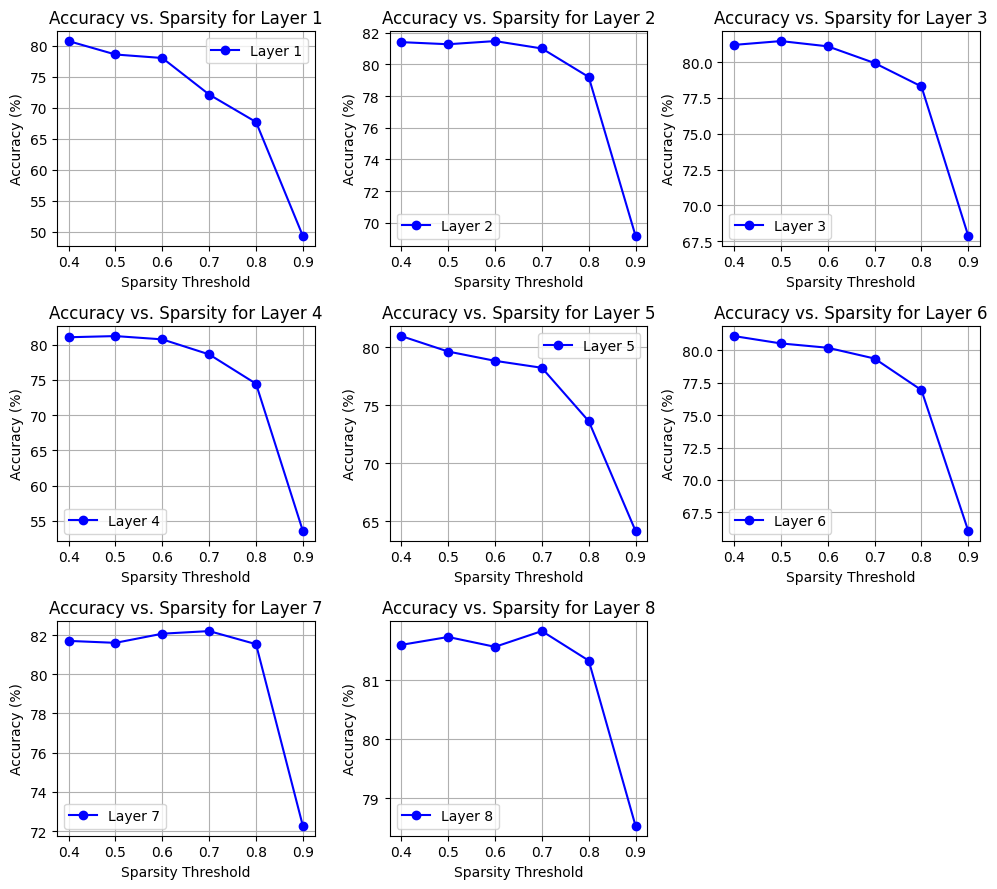

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sparsities(accuracies, sparsities, bins=256, count_nonzero_only=False):
    """
    Plot accuracy vs. sparsity threshold for each convolutional layer.

    :param accuracies: List of accuracies for different sparsities (list of lists).
    :param sparsities: List of sparsity thresholds.
    :param bins: Number of bins for visualization (optional, not needed here).
    :param count_nonzero_only: Flag to count only non-zero weights (optional, not needed here).
    """
    # Determine the number of subplots needed
    num_plots = len(accuracies)
    rows = (num_plots // 3) + (num_plots % 3 > 0)  # Calculate rows based on number of layers
    cols = 3  # Set the number of columns to 3
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 3))
    axes = axes.ravel()  # Flatten axes to easily index
    
    # Plot each layer's accuracies against sparsities
    for plot_index, accuracy_list in enumerate(accuracies):
        ax = axes[plot_index]
        
        # Convert accuracy values to float and plot them against sparsities
        accuracy_values = np.array([float(acc) for acc in accuracy_list])
        
        # Plot accuracy vs. sparsity threshold
        ax.plot(sparsities, accuracy_values, marker='o', linestyle='-', color='b', label=f'Layer {plot_index + 1}')
        
        ax.set_xlabel('Sparsity Threshold')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Accuracy vs. Sparsity for Layer {plot_index + 1}')
        ax.grid(True)
        ax.legend()
    
    # If there are extra axes, hide them
    for i in range(num_plots, len(axes)):
        axes[i].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_sparsities(accuracies, sparsities)

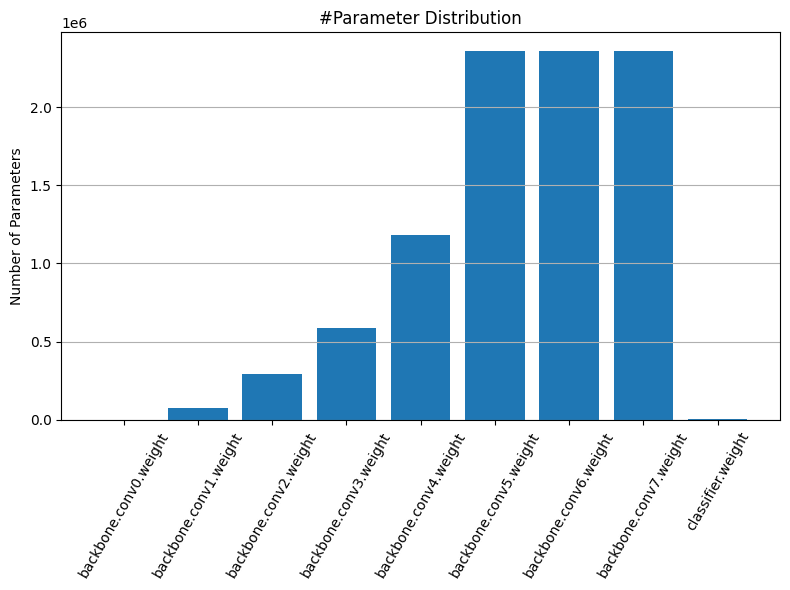

In [21]:

def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [22]:
# Create an empty dictionary to hold the sparsity values for each layer
sparsity_dict = {}

# Assuming `accuracies` and `sparsities` are already defined

# Get the best sparsities from the accuracies (as per previous logic)
best_sparsities = []
for accuracy_list in accuracies:
    accuracy_floats = [float(acc) for acc in accuracy_list]
    best_index = accuracy_floats.index(max(accuracy_floats))
    best_sparsities.append(sparsities[best_index])

# Now iterate through the model layers and match the sparsity with each layer
sparsity_iter = iter(best_sparsities)  # iterator to go through the best sparsities

# Loop through the layers of the model
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        # Get the next best sparsity for the current Conv2d layer
        best_sparsity = next(sparsity_iter)
        
        # Add the sparsity to the dictionary with the layer name as key
        sparsity_dict[name] = best_sparsity

# Print the sparsity dictionary to verify
print(sparsity_dict)


{'backbone.conv0': 0.4, 'backbone.conv1': 0.6, 'backbone.conv2': 0.5, 'backbone.conv3': 0.5, 'backbone.conv4': 0.4, 'backbone.conv5': 0.4, 'backbone.conv6': 0.7, 'backbone.conv7': 0.7}


In [23]:
checkpoint_url = '/media/hp/New Volume/teja_works/tinyml/TinyMLLectureNotes/pruning/best_finetuned_model.pth'
checkpoint = torch.load(checkpoint_url, map_location="cpu")
recover_model = lambda: model.load_state_dict(checkpoint['model_state_dict'])
recover_model()

<All keys matched successfully>

In [24]:

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        # Initialize the pruner by creating masks using the sparsity_dict
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        # Apply the masks to the model weights
        for name, param in model.named_parameters():
            if name in self.masks:
                param.data *= self.masks[name]  # Apply the pruning mask

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()  # Dictionary to store pruning masks for each layer
        for name, param in model.named_parameters():
            if param.dim() > 1:  # We only prune Conv2d and Linear (fully connected) layers
                
                print(name)
                subname = name.replace('.weight', '')
                if subname in sparsity_dict:
                    # Get the sparsity value for this layer from the sparsity_dict
                    sparsity = sparsity_dict[subname]
                    
                    
                    # print("pruned")
                    
                    # Apply the fine-grained pruning to the parameter
                    masks[name] = fine_grained_prune(param, sparsity)
        return masks


In [25]:

pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')


for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")



backbone.conv0.weight
backbone.conv1.weight
backbone.conv2.weight
backbone.conv3.weight
backbone.conv4.weight
backbone.conv5.weight
backbone.conv6.weight
backbone.conv7.weight
classifier.weight
After pruning with sparsity dictionary
  backbone.conv0: 0.40
  backbone.conv1: 0.60
  backbone.conv2: 0.50
  backbone.conv3: 0.50
  backbone.conv4: 0.40
  backbone.conv5: 0.40
  backbone.conv6: 0.70
  backbone.conv7: 0.70
The sparsity of each layer becomes
Sparse model has size=15.34 MiB = 43.58% of dense model size


Sparse model has accuracy=77.43% before fintuning


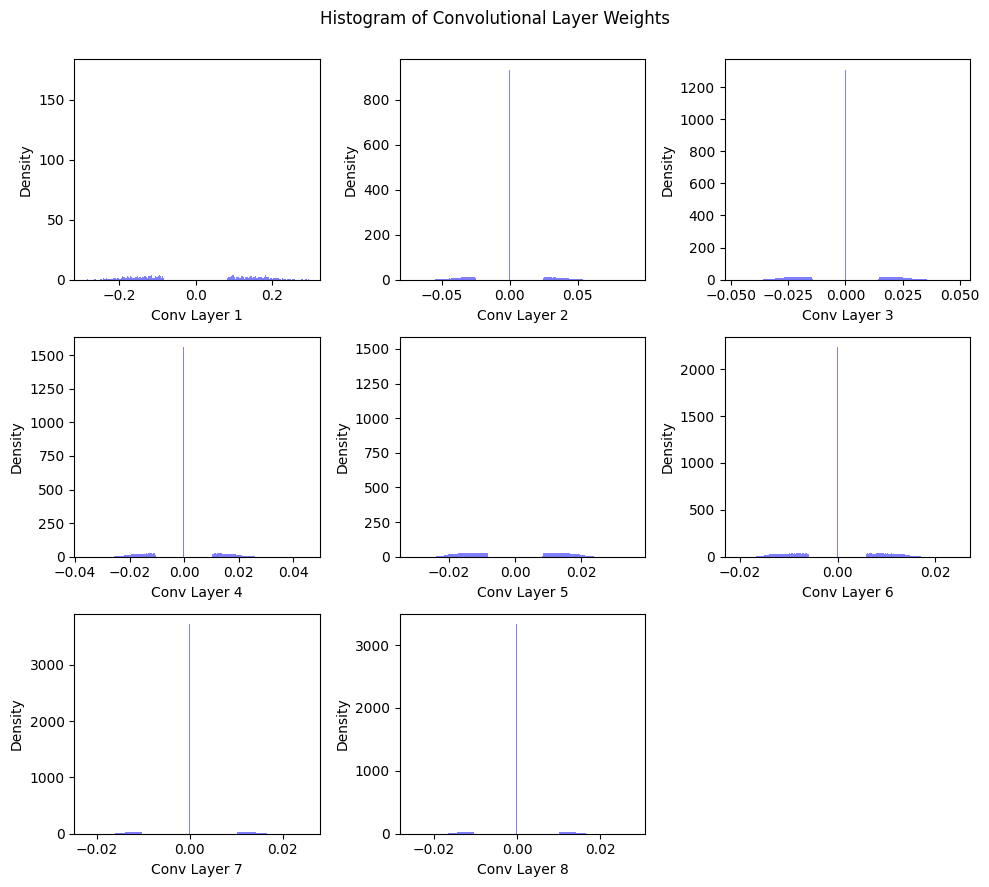

In [26]:
# Call the function with your model
plot_conv_weights(model)

In [31]:
from tqdm import tqdm

# Initialize variables for tracking progress
best_sparse_model_checkpoint = dict()
best_accuracy = 0

print(f'Finetuning Fine-grained Pruned Sparse Model')

num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')

# Training loop
# for epoch in range(num_finetune_epochs):
#     print(f"Epoch [{epoch+1}/{num_finetune_epochs}]")

#     # Train phase
#     train(model, dataloader['train'], criterion, optimizer, scheduler,  callbacks=[lambda: pruner.apply(model)])

    # is_best = accuracy > best_accuracy
    # if is_best:
    #     best_sparse_model_checkpoint['model_state_dict'] = copy.deepcopy(model.state_dict())
    #     best_accuracy = accuracy
    # print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
    
    
best_sparse_model_checkpoint['model_state_dict'] = copy.deepcopy(model.state_dict())
    
# Save the best model checkpoint after training is complete
torch.save(best_sparse_model_checkpoint, 'best_finetuned_sparse_model.pth')
print(f"Best model saved with accuracy: {best_accuracy:.2f}%")


Finetuning Fine-grained Pruned Sparse Model
Finetuning Fine-grained Pruned Sparse Model
Best model saved with accuracy: 0.00%


In [ ]:

## after fine tuning the model for few epochs we see that the model is getter better accuracy with half the size of the original model.

# load the best sparse model checkpoint to evaluate the final performance
best_sparse_model_checkpoint = torch.load('/media/hp/New Volume/teja_works/tinyml/TinyMLLectureNotes/pruning/best_finetuned_sparse_model.pth')
model.load_state_dict(best_sparse_model_checkpoint['model_state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=15.34 MiB = 43.58% of dense model size


Sparse model has accuracy=86.13% after fintuning


In [33]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

dense model has accuracy=81.50%


In [34]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


In [35]:
model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

# Channel Pruning

In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    return int(round((1-prune_ratio)*channels))


@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])

    print("Tensor's shape has been changed, but the print info of model doesn't change.")
    return model


In [41]:
dummy_input = torch.randn(1, 3, 224,224).cuda()
recover_model()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)

pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

Tensor's shape has been changed, but the print info of model doesn't change.


pruned model has accuracy=22.97%


In [ ]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]

        # the importance is calculated here.
        importance = torch.norm(channel_weight, p=2)
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))

    return model

In [43]:

channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

 * Without sorting...
Tensor's shape has been changed, but the print info of model doesn't change.


pruned model has accuracy=22.97%
 * With sorting...
Tensor's shape has been changed, but the print info of model doesn't change.


pruned model has accuracy=33.23%


In [44]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Epoch 1 Accuracy 77.80% / Best Accuracy: 77.80%


Epoch 2 Accuracy 81.97% / Best Accuracy: 81.97%


Epoch 3 Accuracy 83.87% / Best Accuracy: 83.87%


Epoch 4 Accuracy 78.43% / Best Accuracy: 83.87%


Epoch 5 Accuracy 81.73% / Best Accuracy: 83.87%


In [45]:

# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')
     

                Original        Pruned          Reduction Ratio
Latency (ms)    2.7             1.5             1.8            
MACs (M)        606             305             2.0            
Param (M)       9.23            5.01            1.8            
